In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv('adult.data',header=None)
df2 = pd.read_csv('adult.test',header=None)
df = pd.concat([df1,df2], axis=0)

In [3]:
df.columns = ['age', 'workclass', 'final_weight', 'education', 'education-num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'class']

In [4]:
def clean_class(i):
        if i.endswith('.'):
            return i[0:-1]
        else:
            return i
    
df['class']=df['class'].apply(clean_class)

In [5]:
df['class'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [6]:
def space(i):
        if type(i)==str:
            return i.strip()
        else:
            return i

In [7]:
df['class']=df['class'].apply(space)

In [8]:
df['class'].unique()

array(['<=50K', '>50K'], dtype=object)

### removing holand netherlands becasue there is only one value

In [9]:
df.drop(index=19609,inplace=True)

In [10]:
df.to_csv('rawdata.csv',index = None)

In [11]:
def preprocess(df):
    df = df.replace(" ?", np.nan)
    cat_columns = list(df.select_dtypes(include = 'object').columns)
    num_columns = list(df.select_dtypes(exclude = 'object').columns)
    
    def space(i):
        if type(i)==str:
            return i.strip()
        else:
            return i
        
    
    
    for col in cat_columns:
        df[col]=df[col].apply(space)
    
    
    
    df.drop('education-num',inplace=True,axis = 1)
    df.drop_duplicates(inplace = True)
    
    return df

In [12]:
df.head()

,age,workclass,final_weight,education,education-num,marital_status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocessed the dataset to make it ready for processing

In [13]:
df = preprocess(df)

<IPython.core.display.Javascript object>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48789 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48789 non-null  int64 
 1   workclass       45994 non-null  object
 2   final_weight    48789 non-null  int64 
 3   education       48789 non-null  object
 4   marital_status  48789 non-null  object
 5   occupation      45984 non-null  object
 6   relationship    48789 non-null  object
 7   race            48789 non-null  object
 8   sex             48789 non-null  object
 9   capital-gain    48789 non-null  int64 
 10  capital-loss    48789 non-null  int64 
 11  hours-per-week  48789 non-null  int64 
 12  native-country  47933 non-null  object
 13  class           48789 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.6+ MB


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from category_encoders.count import CountEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [16]:
numerical_columns = ['age', 'final_weight', 'capital-gain', 'capital-loss', 'hours-per-week']
count_enc_columns = ['workclass','marital_status','occupation','relationship','race','sex','native-country']
ordinal_columns = ['education']



edu_categories = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th',
                 'HS-grad','Some-college','Assoc-voc','Assoc-acdm','Bachelors',
                 'Masters','Prof-school','Doctorate']



num_pipeline = Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    ]
)

ordinal_pipeline = Pipeline(
    steps =[
    ('imputer',SimpleImputer(strategy="most_frequent")),
    ('ordinal',OrdinalEncoder(categories=[edu_categories])),
    ('scaler',StandardScaler())
    ])

cat_encoding_pipeline = Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy="most_frequent")),
    ('countEncoder',CountEncoder()),
    ('scaler',StandardScaler())]
)


preprocessor = ColumnTransformer(
    [
    ("num_pipeline",num_pipeline,numerical_columns),
    ("ordinal_pipeline",ordinal_pipeline,ordinal_columns),
    ("cat_encoding_pipeline",cat_encoding_pipeline,count_enc_columns)

    ]
)

In [17]:
target_column_name = 'class'
X = df.drop(target_column_name,axis = 1)
y= df[target_column_name]

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=123)

In [38]:
y_train.value_counts()

<=50K    24861
>50K      7827
Name: class, dtype: int64

In [19]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [20]:
X_train.shape,X_test.shape

((32688, 13), (16101, 13))

In [21]:
lr= LogisticRegression(class_weight='balanced')

In [22]:
hyperparams = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["newton-cg", "lbfgs",'liblinear' "sag", "saga"],
    "max_iter": [100, 500, 1000]
}


In [23]:
gs=GridSearchCV(lr,hyperparams)

In [24]:
gs.fit(X_train,y_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: So

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinearsag',
                                    'saga']})

In [25]:
gs.best_params_

{'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

In [26]:
lr.set_params(**gs.best_params_)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000, solver='saga')

In [27]:
lr.fit(X_train,y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=1000, solver='saga')

In [28]:
y_pred = lr.predict(X_test)

In [29]:
accuracy_score(y_test,y_pred)

0.7982733991677535

In [30]:
confusion_matrix(y_test,y_pred)

array([[9699, 2548],
       [ 700, 3154]], dtype=int64)

In [31]:
roc_auc_score(y_test,lr.predict_proba(X_test)[:,1])

0.8863275837353854

In [32]:
y_test.value_counts()

<=50K    12247
>50K      3854
Name: class, dtype: int64

In [33]:
pd.DataFrame(y_pred).value_counts()

<=50K    10399
>50K      5702
dtype: int64

In [34]:
cm=confusion_matrix(y_test,y_pred)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

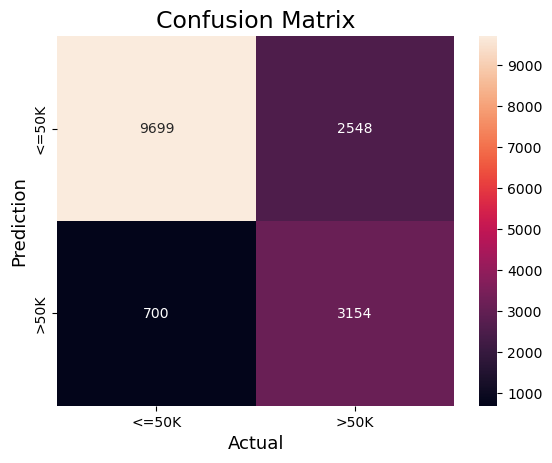

In [35]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K']
            )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

Here <=50k is Positive and >50k is Negative

For Our dataset, False-Negatives should be decreased,
If a person is falsely predicted that he belong to a >50k data group, He may receive less
resources than what he should recieve actually, as he belongs to low income group.

So We should try to reduce False-Negatives
So recall will be our main performance metric.

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.93      0.79      0.86     12247
        >50K       0.55      0.82      0.66      3854

    accuracy                           0.80     16101
   macro avg       0.74      0.81      0.76     16101
weighted avg       0.84      0.80      0.81     16101



### recall = TP/(TP+FN)

In [42]:
cm

array([[9699, 2548],
       [ 700, 3154]], dtype=int64)

In [44]:
cm[0][0]/(cm[0][0]+cm[1][0])

0.9326858351764593